# Setup

In [10]:
import os
import subprocess
import sys
import warnings

warnings.filterwarnings("ignore")

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "neuralgeom"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

Working directory:  /home/facosta/neuralgeom/neuralgeom
Directory added to path:  /home/facosta/neuralgeom
Directory added to path:  /home/facosta/neuralgeom/neuralgeom


# Imports

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import json

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

import default_config as config
import neuralgeom.datasets.utils as utils
import neuralgeom.models.neural_vae as neural_vae
import train
import viz

INFO:root:Using pytorch backend


# Get config on run of interest

In [35]:
run_id = "6d800738"
#expt = "34"

CONFIG_DIR = os.path.join(os.getcwd(), "results", "configs")

print(f"Config in directory: {CONFIG_DIR}:")
for config_file in os.listdir(CONFIG_DIR):
    if run_id in config_file:
        print(config_file)
        run_id_config_file = config_file

with open(
    os.path.join(CONFIG_DIR, run_id_config_file),
    "r",
) as f:
    config_dict = json.load(f)

# Convert a dict into an object where attributes are accessed with "."
# This is needed for the utils.load() function
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


config = AttrDict(config_dict)
config;

Config in directory: /home/facosta/neuralgeom/neuralgeom/results/configs:
run_6d800738_t2_synthetic_noise_var_0.001_embedding_dim_3.json


# Get data and curvature profile

## Load data

In [36]:
dataset_torch, labels, train_loader, test_loader = utils.load(config)
dataset_torch = dataset_torch.to(config.device)
_, data_dim = dataset_torch.shape

Dataset shape: torch.Size([1936, 3]).


## Load model

In [37]:
trained_models_dir = os.path.join(os.getcwd() + "/results/trained_models")

model_path = os.path.join(trained_models_dir, f"{config.results_prefix}_model.pt")
model = torch.load(model_path)

## Get learned immersion $f$ and neural metric

In [38]:
import geomstats.backend as gs
from geomstats.geometry.pullback_metric import PullbackMetric

import evaluate

learned_immersion = evaluate.get_learned_immersion(model, config)

neural_metric = PullbackMetric(
    dim=1, embedding_dim=config.data_dim, immersion=learned_immersion
)

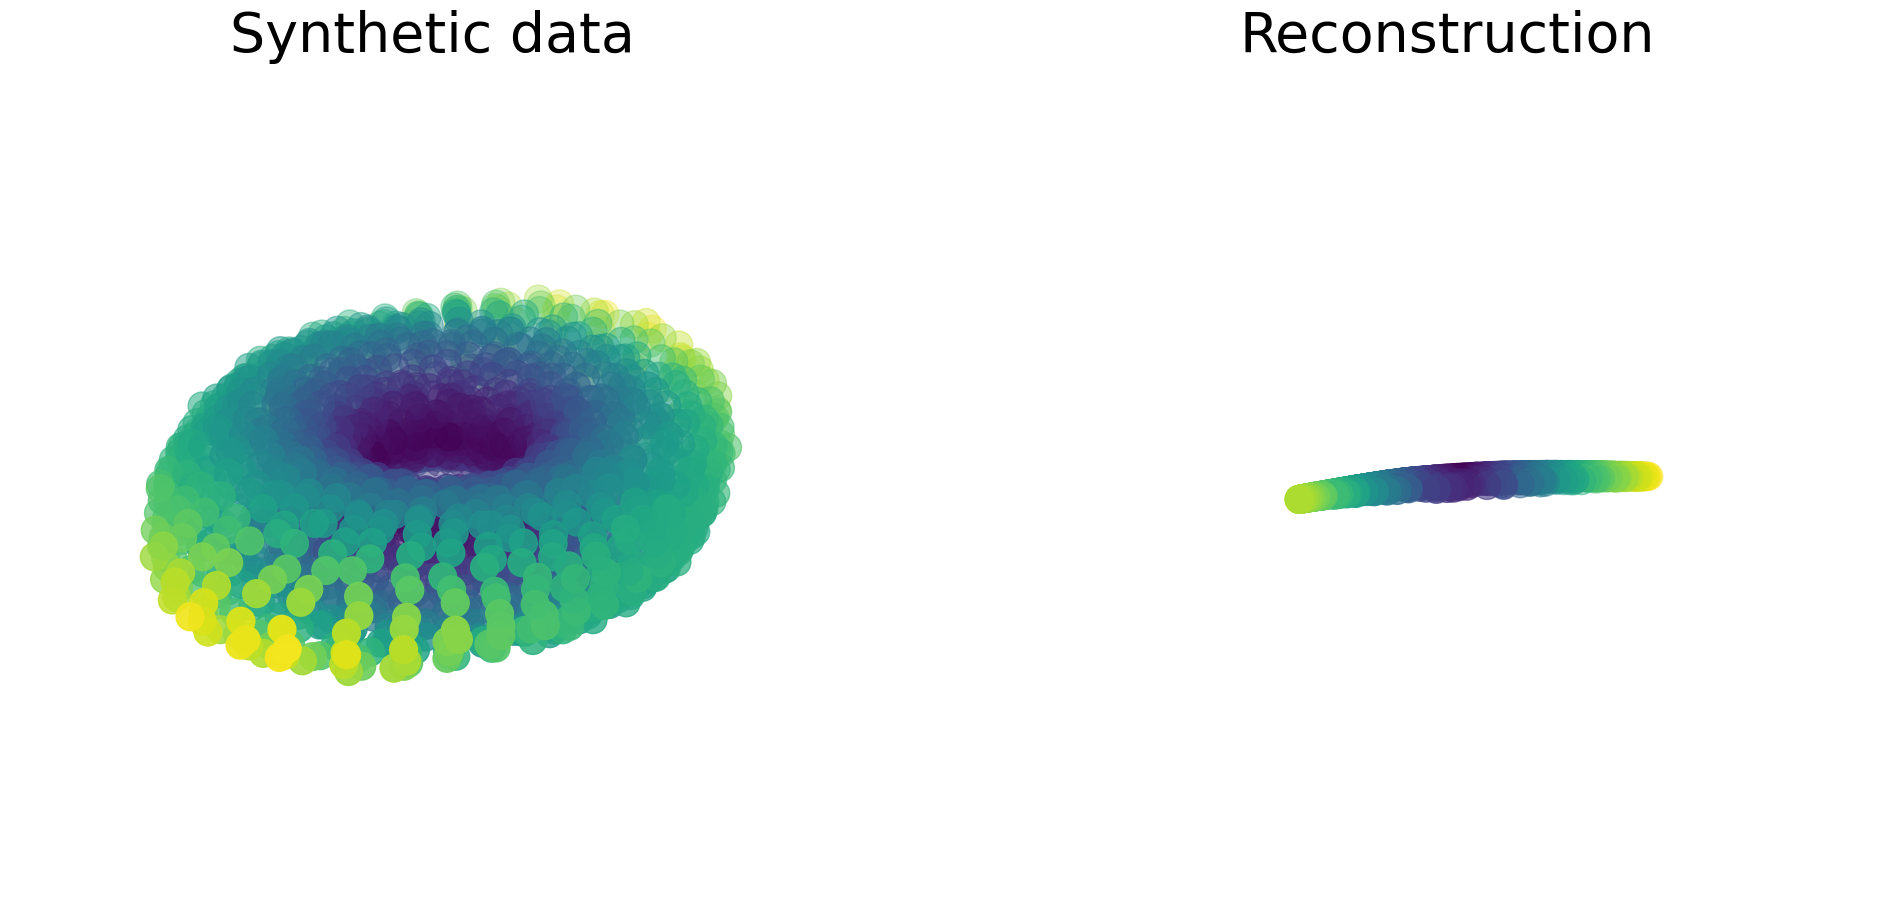

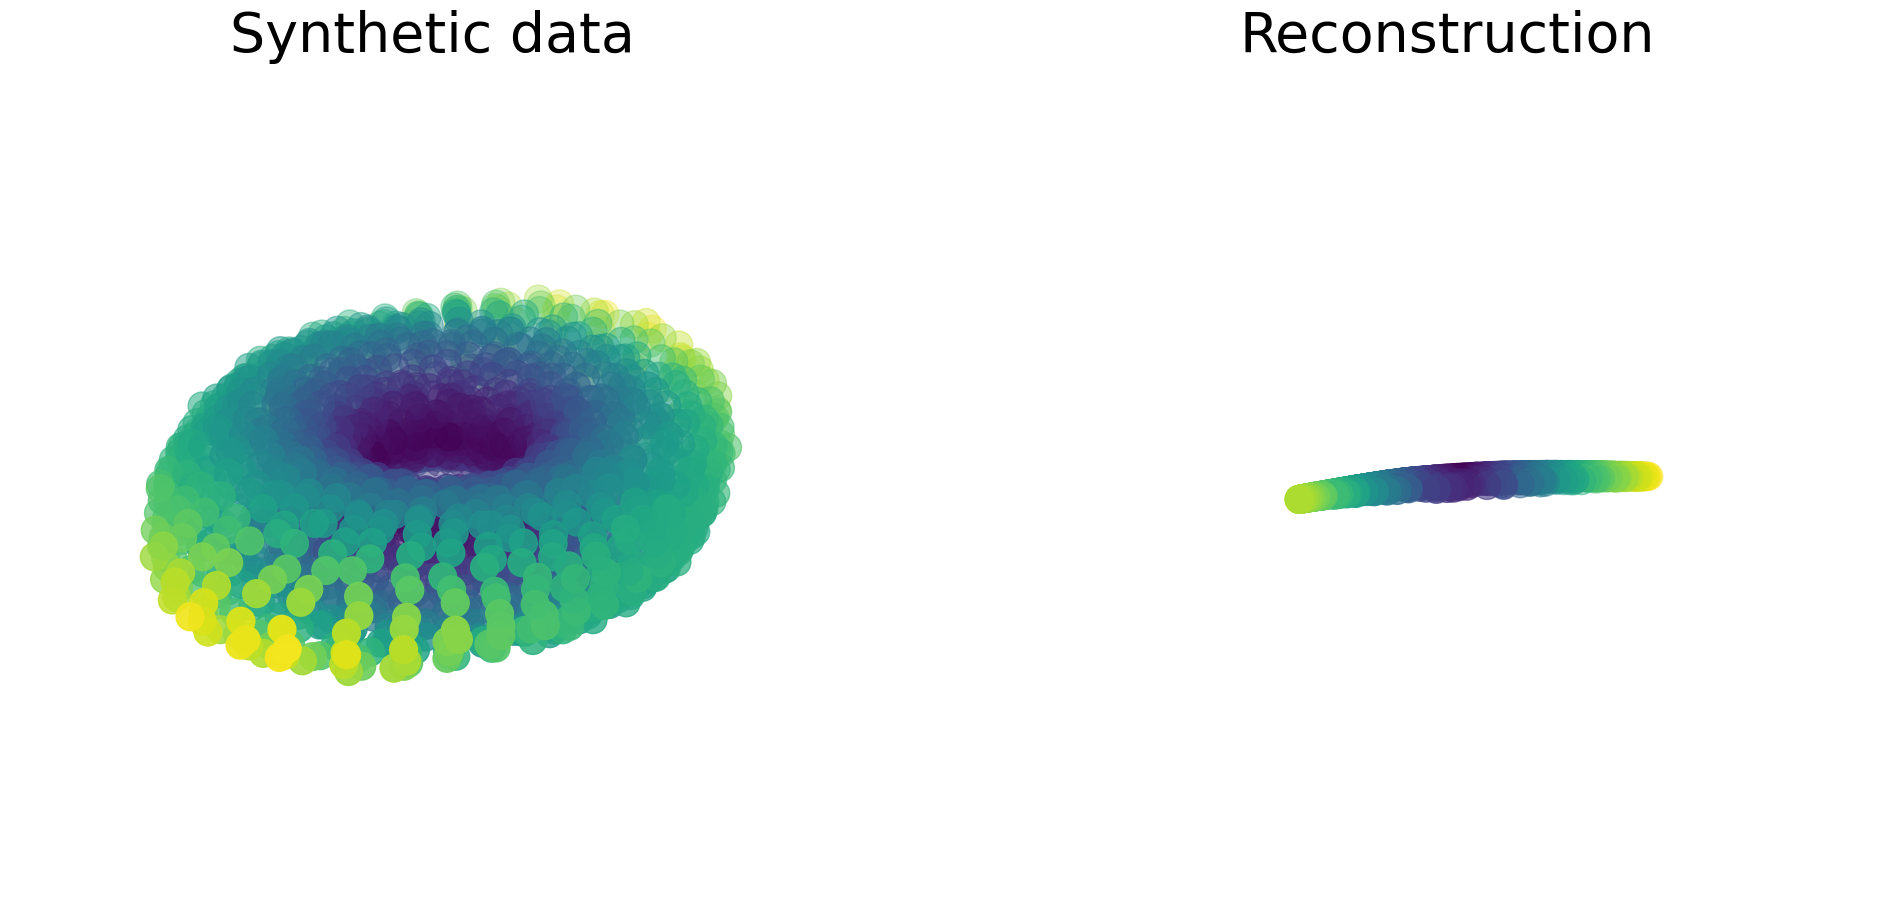

In [59]:
viz.plot_recon_per_positional_angle(model, dataset_torch, labels, config)

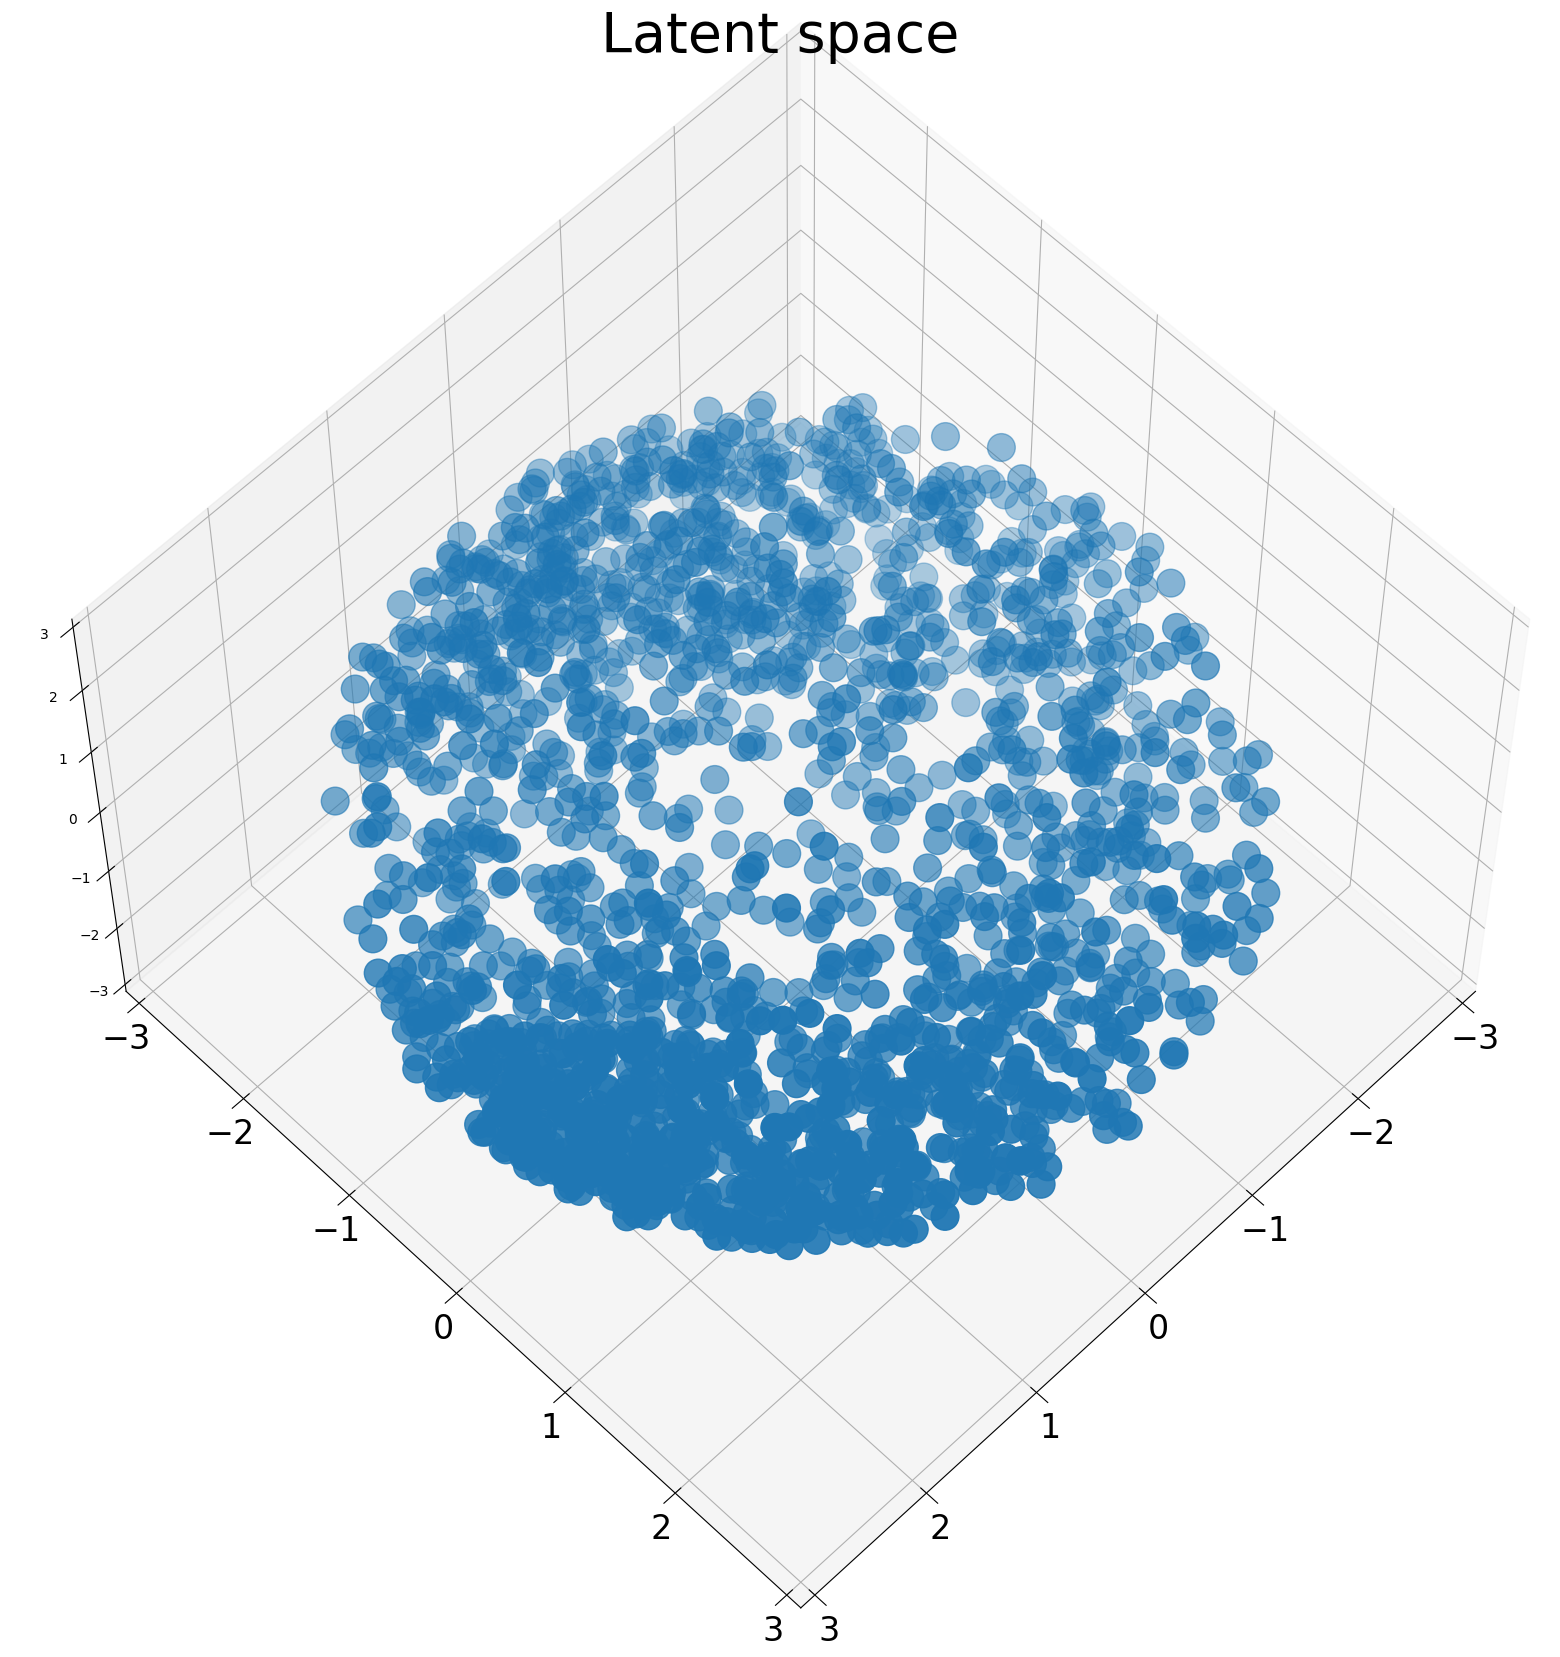

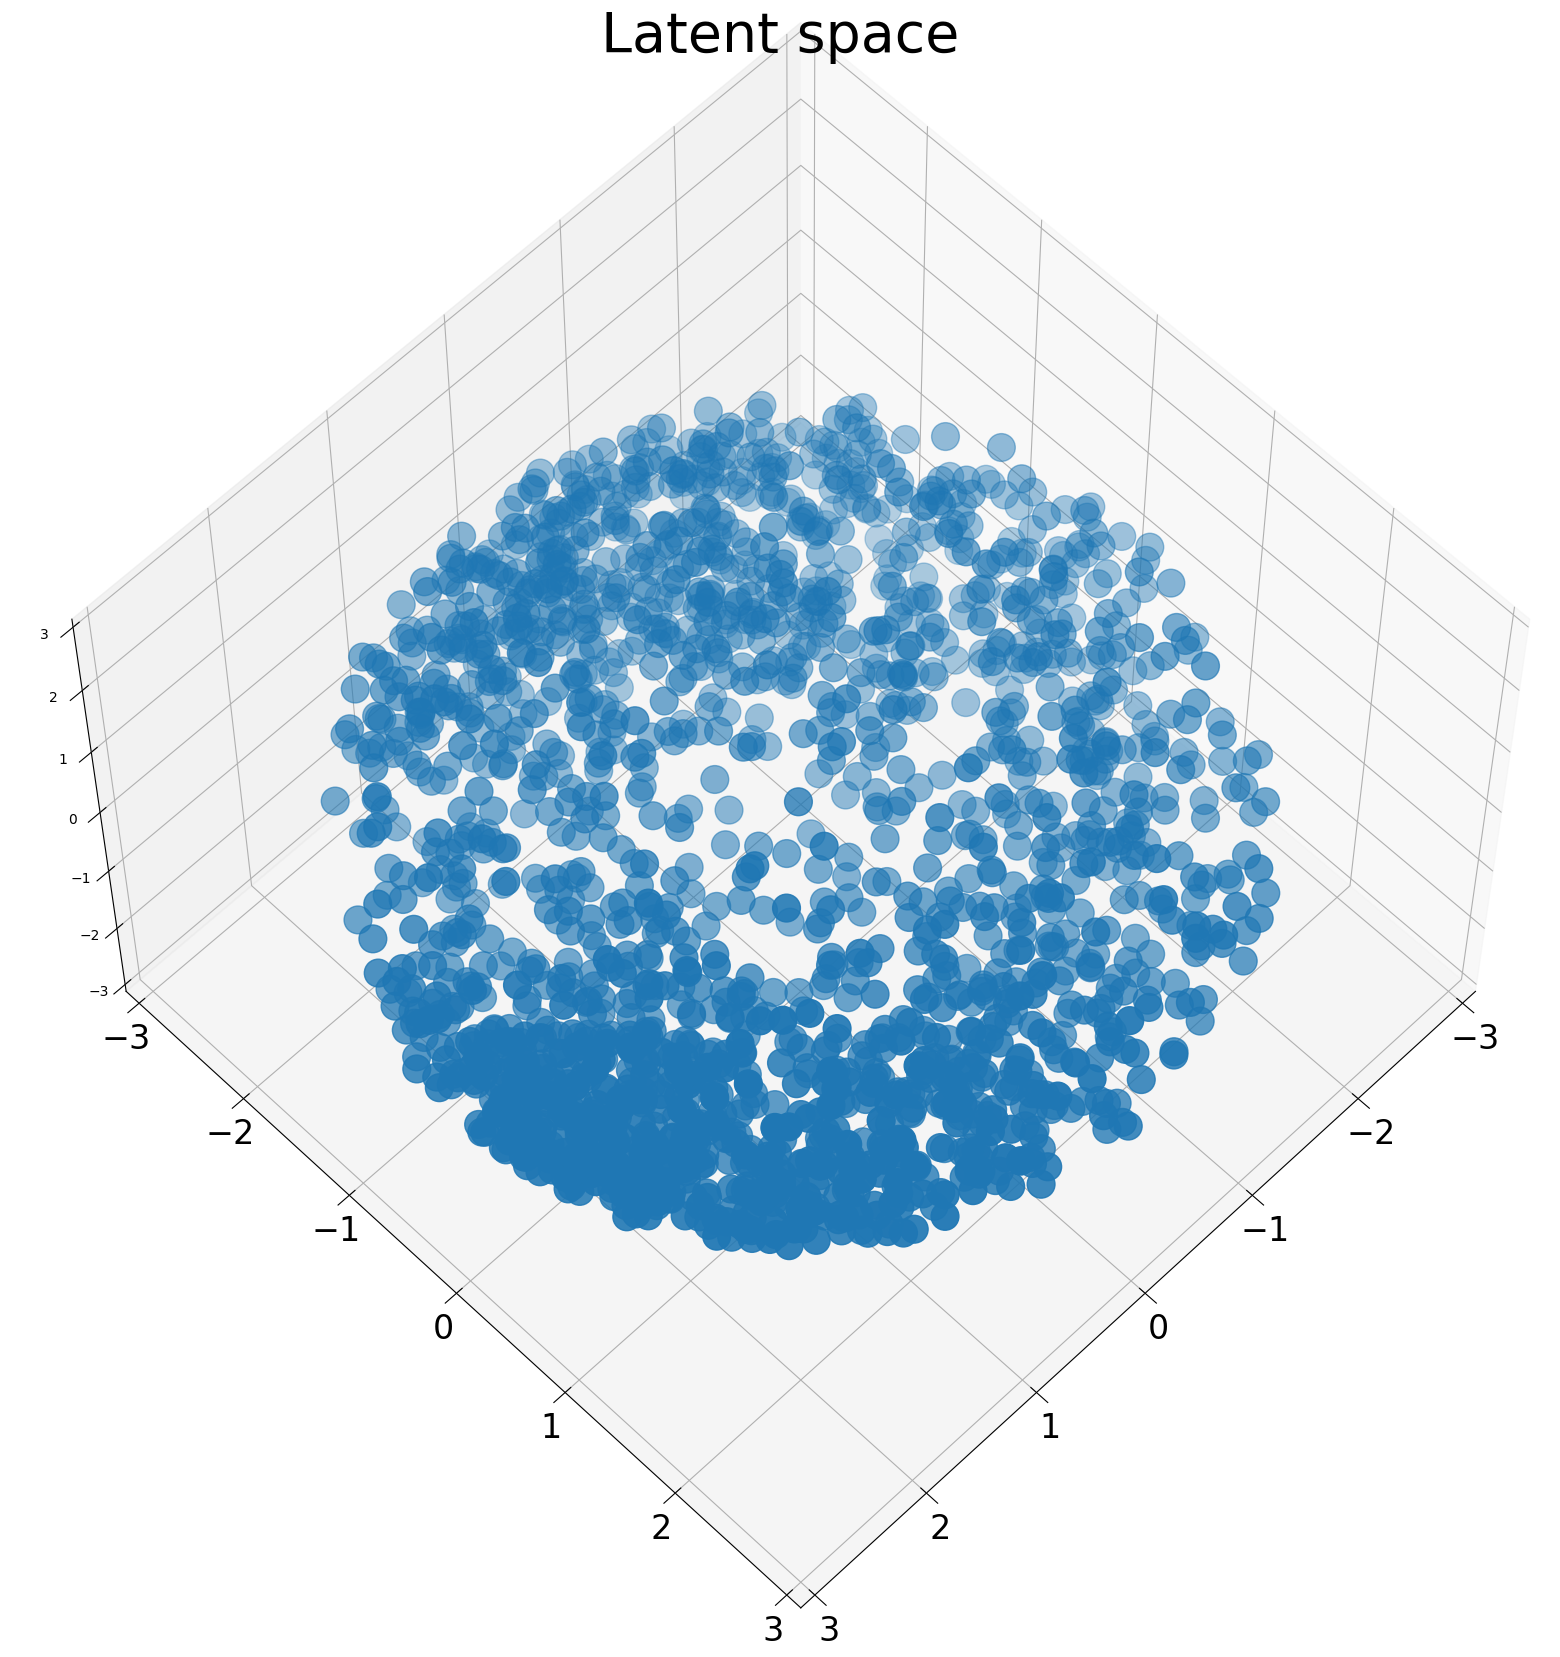

In [60]:
viz.plot_latent_space(model, dataset_torch, labels, config)

## Load learned curvature profile

In [61]:
CURVATURE_PROFILES_DIR = os.path.join(os.getcwd(), "results", "curvature_profiles")

curv_norm_learned_profile = pd.read_csv(
    os.path.join(
        CURVATURE_PROFILES_DIR, config.results_prefix + "_curv_norm_learned_profile.csv"
    )
)

In [64]:
curv_norm_learned_profile

,Unnamed: 0,z_grid_theta,z_grid_phi,geodesic_dist,curv_norm_learned
0,0,0.000000,0.000000,0.0,4872.351909
1,1,0.000000,0.146121,0.0,4640.907552
2,2,0.000000,0.292241,0.0,52.095364
3,3,0.000000,0.438362,0.0,1.309370
4,4,0.000000,0.584482,0.0,1.000448
...,...,...,...,...,...
1931,1931,6.283185,5.698703,0.0,67.686625
1932,1932,6.283185,5.844824,0.0,99.435659
1933,1933,6.283185,5.990944,0.0,166.928042
1934,1934,6.283185,6.137065,0.0,423.302791


# Compute geodesic distances

In [ ]:
import copy
import logging

from joblib import Parallel, delayed

model.to("cuda:0")

z_grid_theta = torch.tensor(curv_norm_learned_profile["z_grid_theta"].values)  # ??
z_grid_phi = torch.tensor(curv_norm_learned_profile["z_grid_phi"].values)  # ??

z0 = gs.array([z_grid_theta[0], z_grid_phi[0]])
assert z0.shape == (2, 1), z0.shape


# TODO (use logging to actually print and know which iterations we are on)
def _geodesic_dist(i_z, z, grid_interval):
    if i_z == 0:
        return (0, torch.tensor(0.0))
    # Parallelize on gpus: is that line really helping,
    # i.e. is the copy taking less time than the computation? if not, don't bother
    # also: does it change anything since neural metric has already been computed and uses the old version of model?
    model_copy = copy.deepcopy(model).to(f"cuda:{i_z % 9}")
    z = torch.unsqueeze(z, dim=0)
    z_previous = torch.unsqueeze(z_grid[i_z - grid_interval], dim=0)
    start = time.time()
    # Tricks to speed up this computation:
    # 1. Compute with less number of steps for the integration of the geodesic eqn
    # 2. Compute distance between neighboring z's
    dist = neural_metric.dist(z_previous, z, n_steps=7)
    duration = time.time() - start
    logging.info(f"Time (it: {i_z}): {duration:.3f}")
    return (i_z, dist)


# To try this code , use z_grid[:5] to run on smaller batch
# Currently, the z_grid is too big (~800) --> go to 100
# Note: each distance computation takes ~5s.
grid_interval = 1
res = Parallel(n_jobs=-1)(
    delayed(_geodesic_dist)(i_z, z, grid_interval)
    for i_z, z in enumerate(z_grid_phi)
    if i_z % grid_interval == 0
)

In [ ]:
geodesic_dists = torch.zeros(len(res))
curv_norms = torch.zeros(len(res))
for i_z, dist in res:
    geodesic_dists[i_z] = dist
    curv_norms[i_z] = curv_norm_learned_profile["curv_norm_learned"].values[i_z]

print(geodesic_dists[:10])
print(curv_norms[:10])
print(1 / curv_norms[:10])

print(len(geodesic_dists))

In [ ]:
cumul_geodesic_dists = torch.cumsum(geodesic_dists, dim=0)
cumul_geodesic_dists[:10]
print(cumul_geodesic_dists.max())

In [8]:
import subprocess

git_branch = subprocess.check_output(["git", "branch"], universal_newlines=True)